In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys
sys.path.append('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/utils')
print(sys.path)
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import pca_koopman_dir as km
from load_dataset import *
import argparse
import os
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import copy

['/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/utils', '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/utils', '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/utils']


In [22]:
def read_config_file(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

In [23]:
import yaml

config_path = '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/output/experiment_11/config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [24]:
save_dir = config['save_dir']
train_data_dir = config['data_dir_list']
test_data_dir = config['test_dir_list']
# data_dir_list = test_data_dir

train_loss = np.load(os.path.join(save_dir, 'train_losses.npy'))
test_loss = np.load(os.path.join(save_dir, 'test_losses.npy'))


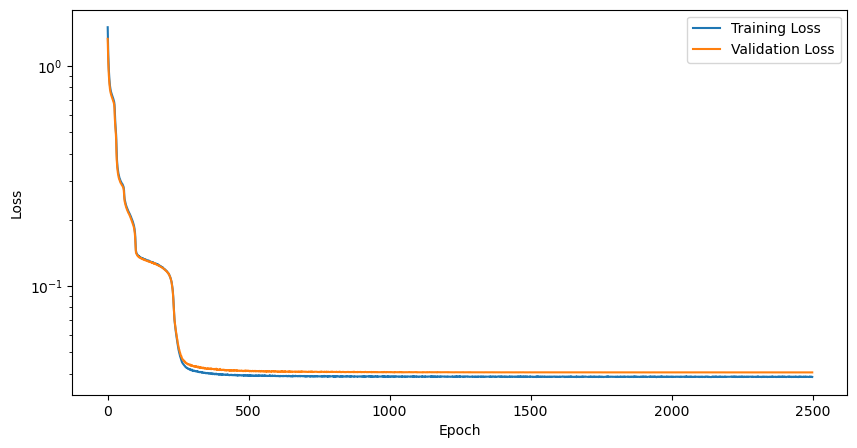

In [25]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [26]:
import pca_koopman_dir as km
import torch
# Device
device = 'cpu'
print('Device:', device)

# todo: multi nu
nu_list = config['nu_list']

# Data loader
x_dataset, u_dataset, nu_dataset = [], [], []
for i in range(len(nu_list)):
    nu = nu_list[i]
    config['data_dir'] = config['data_dir_list'][i]
    x_data, u_data, nu_data, n_features, n_inputs = data_preparation_xu(config, nu_list, nu)
    print(nu_data)
    x_dataset.append(x_data)
    u_dataset.append(u_data)
    nu_dataset.append(nu_data)

params = km.Params(n_features, n_inputs, config)

# Model
if config['experiment'] == 'linear':
    model, x_pca_scaled = km.build_model_linear_multi_nu(params, x_dataset, u_dataset)
if config['experiment'] == 'DicWithInputs':
    model, x_pca_scaled = km.build_model_DicWithInputs_multi_nu(params, x_dataset, u_dataset)
if config['experiment'] == 'MatrixWithInputs':
    model, x_pca_scaled = km.build_model_MatrixWithInputs_multi_nu(params, x_dataset, u_dataset)
model = model.to(device)
# Params

x_data = x_pca_scaled.cpu().numpy()
u_data = np.concatenate(u_dataset, axis=0)
nu_data = np.concatenate(nu_dataset, axis=0)

Device: cpu
0
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
1
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
2
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [27]:
window_size = config['window_size']
predict_num = 2
x_data_slices = cut_slides(x_data, window_size - 1, predict_num)
u_data_slices = cut_slides(u_data, window_size - 1, predict_num)
nu_data_slices = cut_slides(nu_data, window_size - 1, predict_num)
x_data = np.concatenate(x_data_slices, axis=0)
u_data = np.concatenate(u_data_slices, axis=0)
nu_data = np.concatenate(nu_data_slices, axis=0)

print(x_data.shape)
 


(21756, 2, 4)


In [28]:
for i in range(len(nu_list)):
    target = np.zeros(len(nu_list))
    target[i] = 1
    matches = np.all(nu_data[:, 0, :] == target, axis=1)
    indices = np.where(matches)[0]
    print("indices:", indices)

    x1_input = torch.tensor(x_data[indices, 0, :], dtype=torch.float32).to(device)
    y1_input = torch.tensor(x_data[indices, 1, :], dtype=torch.float32).to(device)
    u1_input = torch.tensor(u_data[indices, 0, :], dtype=torch.float32).to(device)

    x1 = model.state_dic(x1_input)
    y1 = model.state_dic(y1_input)
    u1 = model.std_layer_u.transform(u1_input)
    u1 = model.control_encoder(u1)

    z1 = torch.cat((x1, u1), dim=1)

    print(f"z1 shape: {z1.shape}")

    # 计算伪逆
    z1_pseudo_inverse = torch.pinverse(z1)

    # 计算 z1^{-1} @ y1
    param_pseudo_inverse =  torch.matmul(z1_pseudo_inverse, y1)

    A = param_pseudo_inverse[:5, :].T
    B = param_pseudo_inverse[5:, :].T

    with torch.no_grad():
        model.state_matrix.k_matrices[i].weight.copy_(A)
        model.control_matrix.k_matrices[i].weight.copy_(B)

indices: [   0    1    2 ... 7397 7398 7399]
z1 shape: torch.Size([7400, 8])
indices: [ 7400  7401  7402 ... 14501 14502 14503]
z1 shape: torch.Size([7104, 8])
indices: [14504 14505 14506 ... 21753 21754 21755]
z1 shape: torch.Size([7252, 8])


In [29]:
def load_data(begin, end, train_data_dir, nu_list):
    x_dataset = []
    u_dataset = []
    nu_dataset = []
    window_size = end - begin

    for i in range(len(train_data_dir)):
        data_dir = train_data_dir[i]
        nu = nu_list[i]
        nu = torch.tensor(build_nu(nu_list, window_size, nu), dtype=torch.int16)
        for item in os.listdir(data_dir):
            data_file_path = os.path.join(data_dir, item)

            # Check if the file exists before trying to load it
            if os.path.exists(data_file_path) and item.endswith('.npy'):
                data_dict = np.load(data_file_path, allow_pickle=True).item()
                x_data, _, u_data, _ = load_dataset(data_dict)
                x_dataset.append(x_data[begin:end, :])
                u_dataset.append(u_data[begin:end, :])
                nu_dataset.append(nu)
            else:
                print(f"File not found: {data_file_path}")
    
    return x_dataset, u_dataset, nu_dataset

def generate_trajectories(x_dataset, u_dataset, nu_dataset, model, device):
    x_data_pred_traj = []
    x_data_pca_traj = []
    x_data_pca_pred_traj = []
    window_size = len(x_dataset[0])

    for x_data, u_data, nu_data in zip(x_dataset, u_dataset, nu_dataset):
        steps = window_size    

        x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
        u_data = torch.tensor(u_data, dtype=torch.float32).to(device)
        x_pred = torch.zeros_like(x_data).to(device)
        x_pred[0, :] = x_data[0, :]
        nu = nu_data[0:1, :]
        x0 = model.encode(x_data[0, :].reshape(1, -1), nu)
        
        for step in range(1, steps):
            u = u_data[step - 1, :].reshape(1, -1)
            x1 = model.latent_to_latent_forward(x0, u, nu)
            x_pred[step, :] = model.decode(x1, nu)
            x0 = x1
        
        x_data_pred_traj.append(x_pred.detach().cpu().numpy())

        x_pca_true = model.std_layer_1.transform(x_data.detach(), nu_data)
        x_pca_true = model.pca_transformer.transform(x_pca_true)
        x_pca_pred = model.std_layer_1.transform(x_pred.detach(), nu_data)
        x_pca_pred = model.pca_transformer.transform(x_pca_pred)
        
        x_data_pca_traj.append(x_pca_true)
        x_data_pca_pred_traj.append(x_pca_pred)

    return x_data_pred_traj, x_data_pca_traj, x_data_pca_pred_traj

In [30]:
begin, end = 1, 150
window_size = end - begin
x_dataset_train, u_dataset_train, nu_dataset_train = load_data(begin, end, train_data_dir, nu_list)
x_data_pred_traj_train, x_data_pca_traj_train, x_data_pca_pred_traj_train = generate_trajectories(x_dataset_train, u_dataset_train, nu_dataset_train, model, device)
x_dataset_test, u_dataset_test, nu_dataset_test = load_data(begin, end, test_data_dir, nu_list)
x_data_pred_traj_test, x_data_pca_traj_test, x_data_pca_pred_traj_test = generate_trajectories(x_dataset_test, u_dataset_test, nu_dataset_test, model, device)

0


1
2
0
1
2


In [31]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_relative_diff(x_true, x_pred):
    row_norm_diff = np.linalg.norm(x_true - x_pred, axis=1, ord=2)
    max_norm = np.max(np.linalg.norm(x_true, axis=1, ord=2))
    relative_diff = row_norm_diff / max_norm
    return relative_diff

def calculate_mean_relative_diff_set(x_true_traj, x_pred_traj):
    relative_diffs = [calculate_relative_diff(x_true, x_pred) for x_true, x_pred in zip(x_true_traj, x_pred_traj)]
    mean_relative_diffs = np.mean(relative_diffs, axis=0)
    return mean_relative_diffs

def plot_mean_relative_diff(x_true_traj_train, x_pred_traj_train, x_true_traj_test, x_pred_traj_test):
    mean_relative_diffs_train = calculate_mean_relative_diff_set(x_true_traj_train, x_pred_traj_train)
    mean_relative_diffs_test = calculate_mean_relative_diff_set(x_true_traj_test, x_pred_traj_test)

    plt.figure(figsize=(10, 4))
    
    plt.plot(mean_relative_diffs_train, color='mediumseagreen')
    plt.plot(mean_relative_diffs_test, label='Validation Set', color='pink')
    
    plt.xlabel('Prediction Step')
    plt.ylabel('Mean Relative Diff')
    plt.title('Mean Relative Diff on Training and Validation Set')
    plt.legend()
    plt.show()

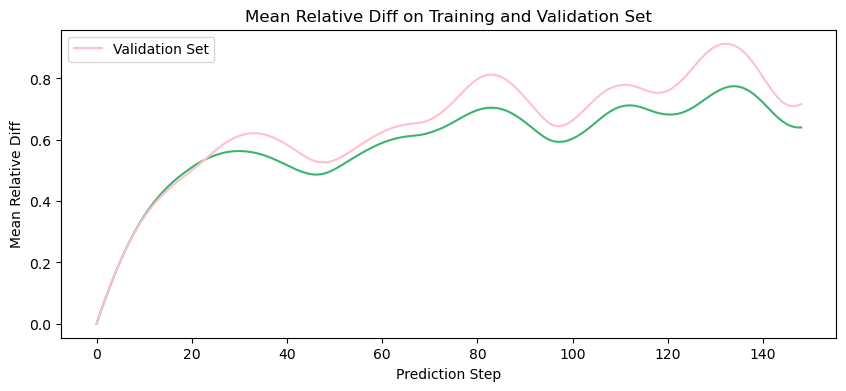

In [32]:
plot_mean_relative_diff(x_data_pca_traj_train, x_data_pca_pred_traj_train, x_data_pca_traj_test, x_data_pca_pred_traj_test)

In [33]:
mean_relative_diffs_train = calculate_mean_relative_diff_set(x_data_pca_traj_train, x_data_pca_pred_traj_train)
mean_relative_diffs_test = calculate_mean_relative_diff_set(x_data_pca_traj_test, x_data_pca_pred_traj_test)
np.save(os.path.join('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/data_for_document/20240708', 'mean_relative_diffs_train_regression.npy'), mean_relative_diffs_train)
np.save(os.path.join('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/data_for_document/20240708', 'mean_relative_diffs_test_regression.npy'), mean_relative_diffs_test)

In [34]:
def calculate_relative_error(x_true, x_pred):
    return np.linalg.norm(x_true - x_pred, ord = 'fro') / np.linalg.norm(x_true, ord = 'fro')

def calculate_mean_relative_error(x_true_traj, x_pred_traj):
    return np.mean([calculate_relative_error(x_true, x_pred) for x_true, x_pred in zip(x_true_traj, x_pred_traj)])

def plot_relative_error(x_true_traj_train, x_pred_traj_train, x_true_traj_test, x_pred_traj_test):
    mean_relative_errors_train = []
    mean_relative_errors_test = []
    for i in range(len(x_true_traj_train)):
        mean_relative_errors_train.append(calculate_relative_error(x_true_traj_train[i], x_pred_traj_train[i]))
    for i in range(len(x_true_traj_test)):
        mean_relative_errors_test.append(calculate_relative_error(x_true_traj_test[i], x_pred_traj_test[i]))
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(9, 7))
    
    ax0.hist(mean_relative_errors_train, bins=50, density=True, histtype='bar', facecolor='yellowgreen', alpha=0.75)
    ax0.set_xlabel('Relative Error')
    ax0.set_ylabel('Frequency')
    ax0.set_title('Training Set')
    
    ax1.hist(mean_relative_errors_test, bins=50, density=True, histtype='bar', facecolor='pink', alpha=0.75)
    ax1.set_title('Validation Set')
    ax1.set_xlabel('Relative Error')
    ax1.set_ylabel('Frequency')
    
    plt.subplots_adjust(hspace=0.4)
    plt.show()


def calculate_relative_error_set(x_true, x_pred):
    row_norm_diff = np.linalg.norm(x_true - x_pred, axis=1, ord=2)
    total_norm_true = np.linalg.norm(x_true, ord='fro')
    return row_norm_diff / total_norm_true

In [35]:
relative_error_train = calculate_mean_relative_error(x_data_pca_traj_train, x_data_pca_pred_traj_train)
relative_error_test = calculate_mean_relative_error(x_data_pca_traj_test, x_data_pca_pred_traj_test)
print(f'Relative error on Training Data: {relative_error_train}', f'Relative error on Test Data: {relative_error_test}')

Relative error on Training Data: 1.075433373451233 Relative error on Test Data: 1.217410922050476


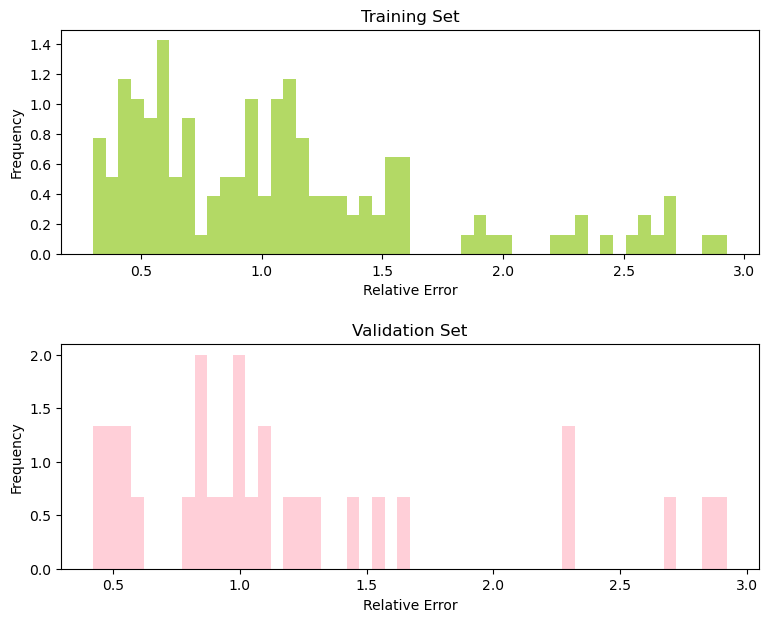

In [36]:
plot_relative_error(x_data_pca_traj_train, x_data_pca_pred_traj_train, x_data_pca_traj_test, x_data_pca_pred_traj_test)

In [37]:
mean_relative_errors_train = []
mean_relative_errors_test = []
for i in range(len(x_data_pca_traj_train)):
    mean_relative_errors_train.append(calculate_relative_error(x_data_pca_traj_train[i], x_data_pca_pred_traj_train[i]))
for i in range(len(x_data_pca_traj_test)):
    mean_relative_errors_test.append(calculate_relative_error(x_data_pca_traj_test[i], x_data_pca_pred_traj_test[i]))

np.save(os.path.join('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/data_for_document/20240708', 'mean_relative_error_train_regression.npy'), mean_relative_errors_train)
np.save(os.path.join('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/data_for_document/20240708', 'mean_relative_error_test_regression.npy'), mean_relative_errors_test)
